In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [3]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [4]:
from src.nettack.GCN import *
from src.nettack.utils import *
from src.nettack.nettack import *
from src.nettack.replication import *
from src.nettack.defense import *

# Graph randomization

## Classical training

In [5]:
Ev = Evaluater()
Ev.load_dataset('src/data/cora.npz')
Ev.create_splits()

Selecting 1 largest connected components
Number of training node : 247
Number of validation nodes : 249
Number of unlabeled (unknown) nodes : 1988


In [6]:
u = Ev.split_unlabeled[0]
u

486

In [7]:
Ev.train_model(surrogate=False, with_perturb=False, disp=True)
Ev.margins[u]

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 51 iterations
Validation accuracy : 89.16%
Train accuracy : 100.00%
Unlabeled accuracy : 83.60%


0.64020085

## Randomize training

In [8]:
EvRand = EvaluaterRand()
EvRand.load_dataset('src/data/cora.npz')
EvRand.split_train = Ev.split_train
EvRand.split_val = Ev.split_val
EvRand.split_unlabeled = Ev.split_unlabeled
EvRand.train_model(surrogate=True, disp=False) # Just because code is boring to change

Selecting 1 largest connected components


In [116]:
EvRand.defend(u, n=3, verbose=False, n_perturbations=5, direct_attack=True,
              perturb_features=True, perturb_structure=False)

In [117]:
EvRand.train_models(surrogate=False, with_perturb=False, disp=True, debug=False)

converged after 28 iterations
Validation accuracy : 84.74%
Train accuracy : 100.00%
Unlabeled accuracy : 85.31%
converged after 86 iterations
Validation accuracy : 84.74%
Train accuracy : 100.00%
Unlabeled accuracy : 84.91%
converged after 66 iterations
Validation accuracy : 85.14%
Train accuracy : 100.00%
Unlabeled accuracy : 86.12%

Validation accuracy : 85.94%
Train accuracy : 100.00%
Unlabeled accuracy : 85.71%


In [118]:
EvRand.margins[u]

0.98688847

## Attack then classical training

In [129]:
Ev.train_model(surrogate=True, disp=False)
Ev.attack(u=u, verbose=False)

In [130]:
Ev.train_model(surrogate=False, with_perturb=True, disp=False)
Ev.margins[Ev.nettack.u]

-0.45005792

## Attack then randomize training

In [143]:
EvRand = EvaluaterRand()
EvRand.load_dataset('src/data/cora.npz')
EvRand.split_train = Ev.split_train
EvRand.split_val = Ev.split_val
EvRand.split_unlabeled = Ev.split_unlabeled
EvRand.train_model(surrogate=True, disp=False) # Just because code is boring to change

Selecting 1 largest connected components


We have :

In [144]:
EvRand.load_attacked_graph(Ev)

In [145]:
EvRand.train_model(surrogate=False, with_perturb=False, disp=False)
EvRand.margins[u]

-0.41442832

But :

In [146]:
EvRand.defend(u, n=3, verbose=False, n_perturbations=5, direct_attack=True,
              perturb_features=True, perturb_structure=False)

In [148]:
EvRand.train_models(disp=True, debug=False)

converged after 78 iterations
Validation accuracy : 84.34%
Train accuracy : 100.00%
Unlabeled accuracy : 85.71%
converged after 43 iterations
Validation accuracy : 86.75%
Train accuracy : 100.00%
Unlabeled accuracy : 85.26%
converged after 28 iterations
Validation accuracy : 84.34%
Train accuracy : 100.00%
Unlabeled accuracy : 85.16%

Validation accuracy : 85.54%
Train accuracy : 100.00%
Unlabeled accuracy : 85.61%


## Bigger study

In [43]:
Ev = Evaluater()
Ev.load_dataset('src/data/cora.npz')
Ev.create_splits()

Selecting 1 largest connected components
Number of training node : 247
Number of validation nodes : 249
Number of unlabeled (unknown) nodes : 1988


Evaluating the number of models

In [44]:
min_n, max_n = 1, 6
repeats = 5
n_u = 5
margins = np.zeros((n_u, max_n - min_n + 1, repeats, 4))

n_perturb = 5
direct = True
perturb_features = True
perturb_struct = True

pbar = tqdm.tqdm_notebook(total=np.size(margins))
for j in range(n_u):
    u = Ev.split_unlabeled[j]
    print(f'u : {u}')
    for r in range(repeats):
        # Classical training
        Ev.train_model(surrogate=False, with_perturb=False, disp=False)
        margins[j, :, r, 0] = Ev.margins[u]
        pbar.update(max_n - min_n + 1)

        # Random training
        EvRand = EvaluaterRand()
        EvRand.load_dataset('src/data/cora.npz')
        EvRand.split_train = Ev.split_train
        EvRand.split_val = Ev.split_val
        EvRand.split_unlabeled = Ev.split_unlabeled
        EvRand.train_model(surrogate=True, disp=False)
        EvRand.defend(u, n=0)    
        for i, n in enumerate(list(range(min_n, max_n + 1))):
            EvRand.add_defender_graph(u, verbose=False, n_perturbations=n_perturb, direct_attack=direct,
                  perturb_features=perturb_features, perturb_structure=perturb_struct)
            EvRand.train_single_model(EvRand.As[-1], EvRand.Xs[-1], disp=False)
            margins[j, i, r, 1] = EvRand.margins[u]
            pbar.update(1)

        # Attack then classical training
        Ev.train_model(surrogate=True, disp=False)
        Ev.attack(u=u, verbose=False)
        Ev.train_model(surrogate=False, with_perturb=True, disp=False)
        margins[j, :, r, 2] = Ev.margins[u]
        pbar.update(max_n - min_n + 1)

        # Attack then random training
        EvRand_attack = EvaluaterRand()
        EvRand_attack.load_dataset('src/data/cora.npz')
        EvRand_attack.split_train = Ev.split_train
        EvRand_attack.split_val = Ev.split_val
        EvRand_attack.split_unlabeled = Ev.split_unlabeled
        EvRand_attack.train_model(surrogate=True, disp=False)
        EvRand_attack.load_attacked_graph(Ev)
        EvRand_attack.defend(u, n=0) 
        for i, n in enumerate(list(range(min_n, max_n + 1))):
            EvRand_attack.add_defender_graph(u, verbose=False, n_perturbations=n_perturb, direct_attack=direct,
                  perturb_features=perturb_features, perturb_structure=perturb_struct)
            EvRand_attack.train_single_model(EvRand_attack.As[-1], EvRand_attack.Xs[-1], disp=False)
            EvRand_attack.defend(u, n=3, verbose=False, n_perturbations=5, direct_attack=True,
                  perturb_features=True, perturb_structure=False)
            margins[j, i, r, 3] = EvRand_attack.margins[u]
            pbar.update(1)
pbar.close()

u : 1324


c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
u : 870
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
u : 2417
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components
Selecting 1 largest connected components

In [45]:
np.save('datasets/margins_random', margins)

<IPython.core.display.Javascript object>


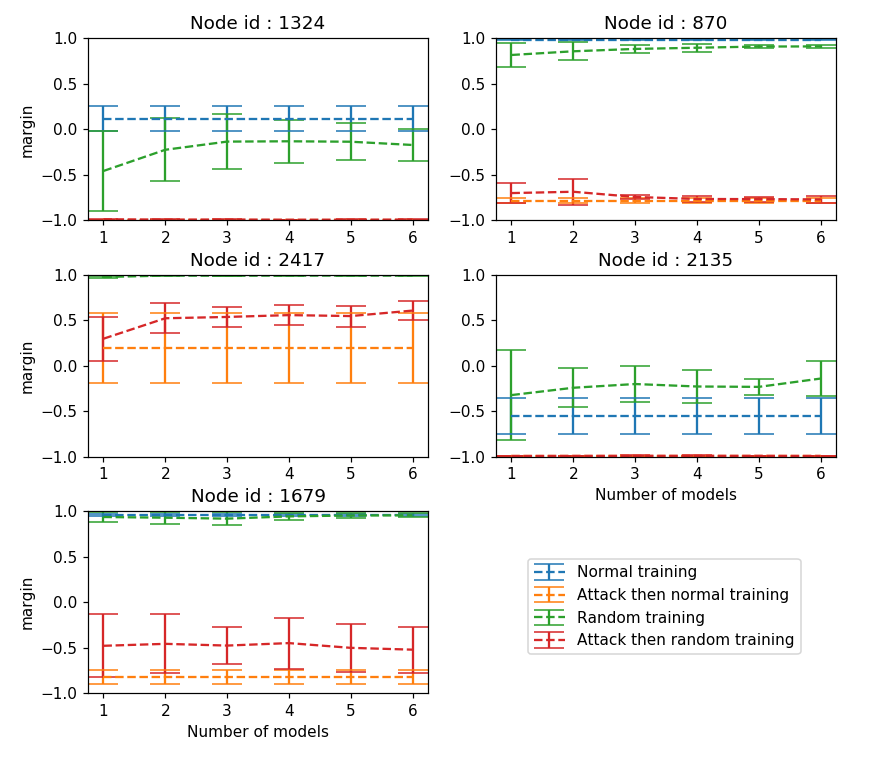

In [98]:
n_models = list(range(min_n, max_n + 1))
fig, axs = plt.subplots(figsize=(8, 7), nrows=3, ncols=2)

for j in range(n_u):
    ax = axs[j//2, j%2]
    if j == 0:
        ax.errorbar(n_models, [margins[j ,0, :, 0].mean()]*len(n_models), yerr=[margins[j, 0, :, 0].std()]*len(n_models),
                     label='Normal training', linestyle='--', capsize=10)
        ax.errorbar(n_models, [margins[j, 0, :, 2].mean()]*len(n_models), yerr=[margins[j, 0, :, 2].std()]*len(n_models),
                     label='Attack then normal training', linestyle='--', capsize=10)
        ax.errorbar(n_models, margins[j, :, :, 1].mean(1), yerr=margins[j, :, :, 1].std(1),
                     label='Random training', linestyle='--', capsize=10)
        ax.errorbar(n_models, margins[j, :, :, 3].mean(1), yerr=margins[j, :, :, 3].std(1),
                     label='Attack then random training', linestyle='--', capsize=10)
    else:
        ax.errorbar(n_models, [margins[j ,0, :, 0].mean()]*len(n_models), yerr=[margins[j, 0, :, 0].std()]*len(n_models),
                    linestyle='--', capsize=10)
        ax.errorbar(n_models, [margins[j, 0, :, 2].mean()]*len(n_models), yerr=[margins[j, 0, :, 2].std()]*len(n_models),
                    linestyle='--', capsize=10)
        ax.errorbar(n_models, margins[j, :, :, 1].mean(1), yerr=margins[j, :, :, 1].std(1),
                    linestyle='--', capsize=10)
        ax.errorbar(n_models, margins[j, :, :, 3].mean(1), yerr=margins[j, :, :, 3].std(1),
                    linestyle='--', capsize=10)
#     ax.legend()
    
    ax.set_ylim(-1, 1)
    ax.set_title(f'Node id : {Ev.split_unlabeled[j]}')
    if j%2 == 0: ax.set_ylabel('margin')
    if j//2 == 2 or j == 3: ax.set_xlabel('Number of models')
    
fig.delaxes(axs[2, 1])
# plt.figlegend(loc='lower right')
plt.figlegend(loc=(0.6, 0.15))
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, hspace=0.3, top=0.95, wspace=0.2)
plt.savefig('figures/random_graph_nodes.pdf', format='pdf')

# Graph optimization

## Normal attack

In [77]:
Ev = Evaluater()
Ev.load_dataset('src/data/cora.npz')
Ev.create_splits()
Ev.train_model(surrogate=True)

Selecting 1 largest connected components
Number of training node : 247
Number of validation nodes : 249
Number of unlabeled (unknown) nodes : 1988


c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


converged after 14 iterations
Validation accuracy : 81.53%
Train accuracy : 100.00%
Unlabeled accuracy : 82.85%


In [78]:
u = Ev.split_unlabeled[0]
u

373

In [79]:
Ev.attack(u=u, verbose=True)

##### Starting attack #####
##### Attack node with ID 373 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [373 787]
##### ...2/5 perturbations ... #####
Edge perturbation: [ 373 2122]
##### ...3/5 perturbations ... #####
Edge perturbation: [ 373 2121]
##### ...4/5 perturbations ... #####
Edge perturbation: [ 373 1422]
##### ...5/5 perturbations ... #####
Edge perturbation: [373 774]


In [80]:
Ev.train_model(surrogate=False, with_perturb=False)
Ev.margins[Ev.nettack.u]

converged after 24 iterations
Validation accuracy : 85.54%
Train accuracy : 100.00%
Unlabeled accuracy : 84.05%


-0.35043725

In [81]:
Ev.train_model(surrogate=False, with_perturb=True)
Ev.margins[Ev.nettack.u]

converged after 28 iterations
Validation accuracy : 84.34%
Train accuracy : 100.00%
Unlabeled accuracy : 84.66%


-0.9972175

## Defending then attacking

In [82]:
EvDef = EvaluaterDef()
EvDef.load_dataset('src/data/cora.npz')
EvDef.split_train = Ev.split_train
EvDef.split_val = Ev.split_val
EvDef.split_unlabeled = Ev.split_unlabeled
EvDef.train_model(surrogate=True, disp=False)

Selecting 1 largest connected components


In [83]:
EvDef.defend(u=u, verbose=True, perturb_features=True)

##### Starting attack #####
##### Attack node with ID 373 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [373 405]
##### ...2/5 perturbations ... #####
Edge perturbation: [ 373 2049]
##### ...3/5 perturbations ... #####
Edge perturbation: [ 373 1241]
##### ...4/5 perturbations ... #####
Edge perturbation: [ 373 2434]
##### ...5/5 perturbations ... #####
Edge perturbation: [ 373 2307]


In [84]:
# If no attack
EvDef.train_model(surrogate=False, with_perturb=False)
EvDef.margins[Ev.nettack.u]

converged after 29 iterations
Validation accuracy : 83.94%
Train accuracy : 100.00%
Unlabeled accuracy : 84.31%


-0.23924547

In [85]:
# attacking on the defended graph
nn = GCN([16, EvDef.K],
         sparse_numpy2sparse_torch(EvDef.nettack.adj_preprocessed),
         sparse_numpy2sparse_torch(EvDef.nettack.X_obs), with_relu=True)
model = GCN_Model(nn, lr=1e-2)
model.train(Ev.split_train, Ev.split_val, Ev.Ztorch, print_info=True, debug=False)
# Computing logits for every node
model._compute_loss_and_backprop(np.arange(Ev.N), Ev.Ztorch, backward=False)
logits = model.logit_nodes.detach().cpu().numpy()
probas = np.exp(logits) / np.exp(logits).sum(1)[:, None]
probas_surr_sorted = np.argsort(-probas, axis=1)
second_l = probas_surr_sorted[np.arange(Ev.N), (probas_surr_sorted == Ev.Z[:, None]).argmin(axis=1)]
margins = (probas[np.arange(Ev.N), Ev.Z] - probas[np.arange(Ev.N), second_l])
margins[Ev.nettack.u]

converged after 38 iterations


0.98006696

## Bigger evaluation

### Cora

In [88]:
Ev = Evaluater()
Ev.load_dataset('src/data/cora.npz')
Ev.create_splits()
Ev.train_model(surrogate=True, disp=False)

EvDef = EvaluaterDef()
EvDef.load_dataset('src/data/cora.npz')
EvDef.split_train = Ev.split_train
EvDef.split_val = Ev.split_val
EvDef.split_unlabeled = Ev.split_unlabeled
EvDef.train_model(surrogate=True, disp=False)

Selecting 1 largest connected components
Number of training node : 247
Number of validation nodes : 249
Number of unlabeled (unknown) nodes : 1988


c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Selecting 1 largest connected components


In [110]:
margins, nodes = evaluate_graph_optim(n_nodes=10, n_retrain=10)

In [111]:
margins.mean(1)

array([[ 0.99850892, -0.99936984,  0.99756885,  0.99999861],
       [ 0.03302533, -0.91940293,  0.0925908 ,  0.99052081],
       [ 0.97546324, -0.04024588,  0.98060873,  0.99756142],
       [ 0.83337374, -0.98811147,  0.83941042,  0.9971488 ],
       [ 0.94310045, -0.8598625 ,  0.94944282,  0.99712673],
       [-0.83084099, -0.99970549, -0.85522097, -0.75348406],
       [ 0.86471704, -0.94760023,  0.91002108,  0.99914728],
       [ 0.36517015, -0.80328937,  0.3790491 ,  0.99527744],
       [ 0.99945073, -0.9719606 ,  0.99943139,  0.99999596],
       [ 0.9990738 , -0.68916427,  0.99913055,  0.99999229]])

<IPython.core.display.Javascript object>


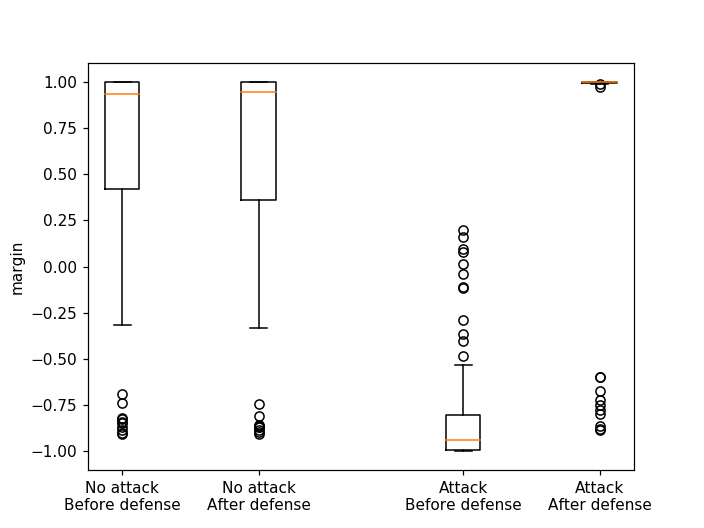

In [136]:
plt.figure()
plt.boxplot(np.stack([margins[:, :, i].flatten() for i in [0, 2, 1, 3]], axis=1),
            labels=['No attack\nBefore defense', 'No attack\nAfter defense',
                    'Attack\nBefore defense' ,'Attack\nAfter defense'],
            positions=[0, 2, 5, 7])
plt.ylabel('margin')
plt.savefig('figures/defense_optim_cora.pdf', format='pdf')

### Citeseer

In [141]:
Ev = Evaluater()
Ev.load_dataset('src/data/citeseer.npz')
Ev.create_splits()
Ev.train_model(surrogate=True, disp=False)

EvDef = EvaluaterDef()
EvDef.load_dataset('src/data/citeseer.npz')
EvDef.split_train = Ev.split_train
EvDef.split_val = Ev.split_val
EvDef.split_unlabeled = Ev.split_unlabeled
EvDef.train_model(surrogate=True, disp=False)

Selecting 1 largest connected components
Number of training node : 210
Number of validation nodes : 211
Number of unlabeled (unknown) nodes : 1688


c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Selecting 1 largest connected components


In [142]:
margins, nodes = evaluate_graph_optim(Ev, EvDef, n_nodes=10, n_retrain=10)

In [143]:
margins.mean(1)

array([[ 0.76091799, -0.98735878,  0.74376205,  0.99949932],
       [ 0.99333258,  0.20506371,  0.99299928,  0.99934271],
       [-0.3631267 , -0.74665266, -0.33091108,  0.45213369],
       [ 0.84271038, -0.95481218,  0.83337935,  0.99796005],
       [ 0.89974495, -0.79706689,  0.92122648,  0.99150458],
       [ 0.88763765, -0.92546796,  0.85977398,  0.99788845],
       [-0.39212857, -0.88096324, -0.39366346,  0.72684661],
       [-0.94193183, -0.99991928, -0.94326178, -0.90322911],
       [ 0.93611115, -0.93022084,  0.90021124,  0.99539099],
       [-0.33992235, -0.9872505 , -0.33271528,  0.97981375]])

<IPython.core.display.Javascript object>


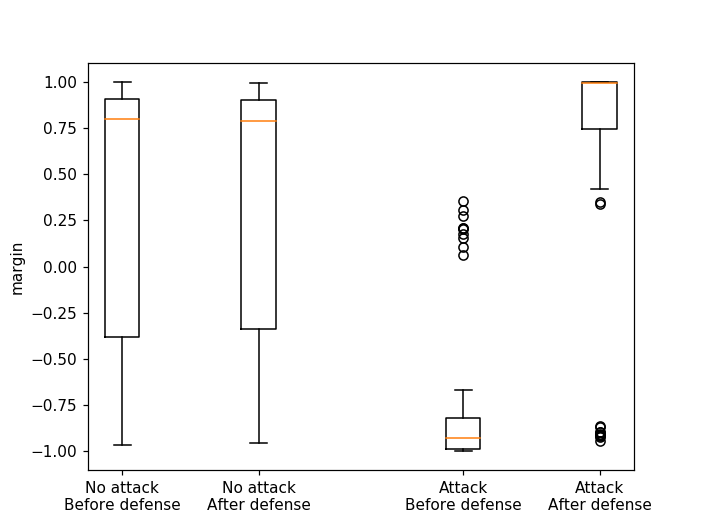

In [145]:
plt.figure()
plt.boxplot(np.stack([margins[:, :, i].flatten() for i in [0, 2, 1, 3]], axis=1),
            labels=['No attack\nBefore defense', 'No attack\nAfter defense',
                    'Attack\nBefore defense' ,'Attack\nAfter defense'],
            positions=[0, 2, 5, 7])
plt.ylabel('margin')
plt.savefig('figures/defense_optim_citeseer.pdf', format='pdf')

<IPython.core.display.Javascript object>


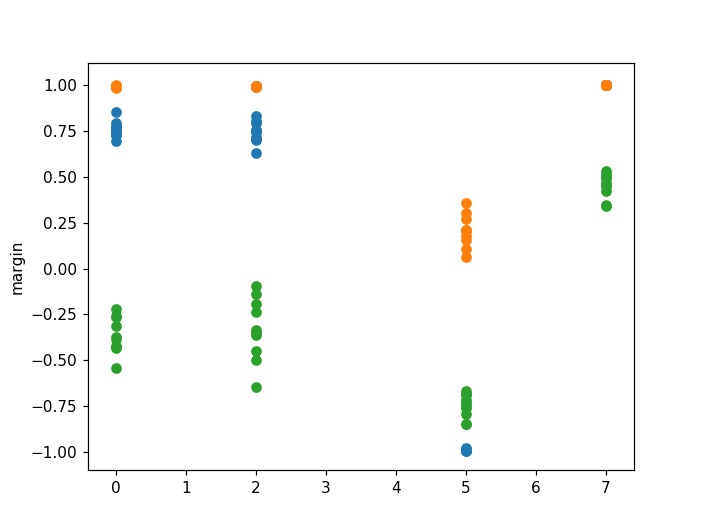

Text(0, 0.5, 'margin')

In [150]:
dict_i_color = dict(zip(list(range(10)), ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                        'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']))
plt.figure()
for i in range(3):
    if i == 0:
        plt.scatter([0]*10, margins[i, :, 0], label='No attack\nBefore defense', c=dict_i_color[i])
        plt.scatter([2]*10, margins[i, :, 2], label='No attack\After defense', c=dict_i_color[i])
        plt.scatter([5]*10, margins[i, :, 1], label='Attack\nBefore defense', c=dict_i_color[i])
        plt.scatter([7]*10, margins[i, :, 3], label='Attack\After defense', c=dict_i_color[i])
    else:
        plt.scatter([0]*10, margins[i, :, 0], c=dict_i_color[i])
        plt.scatter([2]*10, margins[i, :, 2], c=dict_i_color[i])
        plt.scatter([5]*10, margins[i, :, 1], c=dict_i_color[i])
        plt.scatter([7]*10, margins[i, :, 3], c=dict_i_color[i])
plt.ylabel('margin')

### PolBlogs

In [11]:
from scipy.io import mmread
A = mmread('src/data/polblogs.mtx')

In [7]:
_A_obs, _X_obs, _z_obs = load_npz('src/data/polblogs.npz')